In [5]:
import subprocess
import os
import sys

import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
from utils import *

Essential idea: A perturbation that changes a few genes a lot but leaves most others the same (as often seen in CRISPR screens) will easily be missed by umap and others. So we check the top affected genes only.

How to make this a score per perturbation:
- Compute top 10 DEGs of perturbation vs control + DE scores. We call this DEG profile.
- Take mean or compute any other measure (e.g. entropy) on these DEG profiles.


# Example: OT227

In [16]:
# load and prep data
adata = sc.read("/fast/work/users/peidlis_c/data/NB001_8organoid_perturbation/NB001_s001_8organoid_perturbation/NB001_s001_demuxed_preprocessed.h5")
adata.obs = adata.obs.rename({'condition': 'perturbation'}, axis=1)
adata.obs.perturbation = adata.obs.perturbation.cat.rename_categories({'CTRL': 'control'})
adata = adata[adata.obs.perturbation!='nan'].copy()
adata = adata[adata.obs.donor=='OT227'].copy()

In [18]:
# get DEGs
sc.tl.rank_genes_groups(adata, groupby='perturbation', reference='control')  # I think this expects log-ed data
names = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'])

In [19]:
# compute mean and entropy of topDEG profiles
n_top = 10
from scipy.stats import entropy
perturbations = list(pd.unique(adata.obs.perturbation))
perturbations.remove('control')
tab = pd.DataFrame(index=perturbations, columns=['mean', 'entropy'])
for perturbation in perturbations:
    s = np.array(scores[perturbation])
    n = np.array(names[perturbation])
    ent = entropy(s[:n_top] - np.min(s[:n_top]))
    mean = np.mean(s[:n_top])
    tab['mean'].loc[perturbation] = mean
    tab['entropy'].loc[perturbation] = ent

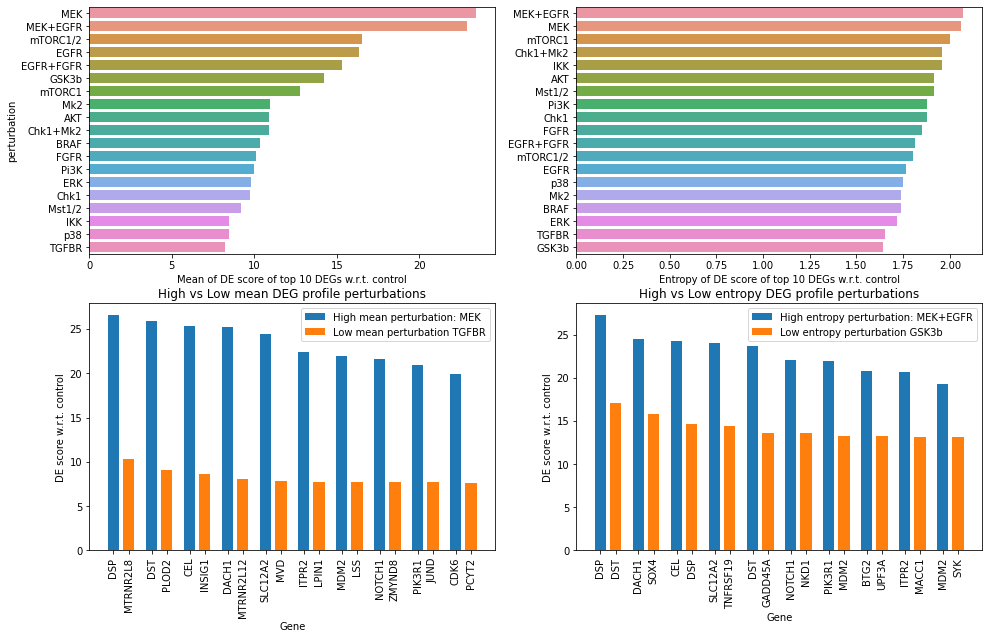

In [47]:
# plot
fig, axss = pl.subplots(2,2, figsize=[16,10])

ax = axss[0,0]
sns.barplot(data=tab.reset_index().sort_values('mean', ascending=False), y='index', x='mean', ax=ax)
ax.set_ylabel('perturbation')
ax.set_xlabel('Mean of DE score of top 10 DEGs w.r.t. control')

ax = axss[0,1]
sns.barplot(data=tab.reset_index().sort_values('entropy', ascending=False), y='index', x='entropy', ax=ax)
ax.set_ylabel('')
ax.set_xlabel('Entropy of DE score of top 10 DEGs w.r.t. control')

ax = axss[1,0]
key = 'mean'#'entropy'
high = tab.index[np.argmax(tab[key])]
low = tab.index[np.argmin(tab[key])]
ax.bar(np.arange(n)-0.2, scores[high][:n_top], width=0.3, label=f'High {key} perturbation: {high}')
ax.bar(np.arange(n)+0.2, scores[low][:n_top], width=0.3, label=f'Low {key} perturbation {low}')
ax.legend()
ax.set_xticks(list(np.arange(n_top)-0.2) + list(np.arange(n_top)+0.2), list(names[high][:n_top]) + list(names[low][:n_top]), rotation=90)
ax.set_xlabel('Gene')
ax.set_ylabel('DE score w.r.t. control')
ax.set_title(f'High vs Low {key} DEG profile perturbations')

ax = axss[1,1]
key = 'entropy'
high = tab.index[np.argmax(tab[key])]
low = tab.index[np.argmin(tab[key])]
ax.bar(np.arange(n)-0.2, scores[high][:n_top], width=0.3, label=f'High {key} perturbation: {high}')
ax.bar(np.arange(n)+0.2, scores[low][:n_top], width=0.3, label=f'Low {key} perturbation {low}')
ax.legend()
ax.set_xticks(list(np.arange(n_top)-0.2) + list(np.arange(n_top)+0.2), list(names[high][:n_top]) + list(names[low][:n_top]), rotation=90)
ax.set_xlabel('Gene')
ax.set_ylabel('DE score w.r.t. control')
ax.set_title(f'High vs Low {key} DEG profile perturbations')
pl.savefig('../../figures/DEG_profile_OT227organoid.pdf', bbox_inches='tight')
pl.show()

# Example: ShifrutMarson2018

In [6]:
data_path = '/extra/stefan/data/perturbation_resource_paper/'

adata = read_from_singles(f"{data_path}ShifrutMarson2018")

In [7]:
sc.pp.filter_cells(adata, min_counts=1000)
sc.pp.filter_genes(adata, min_cells=50)
N = 300 #np.min(adata.obs.perturbation.value_counts())
selection = np.hstack(np.array([np.random.choice(adata.obs_names[adata.obs.perturbation==p], 
                                                size=np.min([N, np.sum(adata.obs.perturbation==p)-1]), replace=False) 
                               for p in pd.unique(adata.obs.perturbation)]))
adata = adata[selection].copy()

sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)

In [8]:
# get DEGs
sc.tl.rank_genes_groups(adata, groupby='perturbation')#, reference='control')  # I think this expects log-ed data
names = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'])

In [28]:
# compute mean and entropy of topDEG profiles
n_top = 100
from scipy.stats import entropy, zscore
perturbations = list(pd.unique(adata.obs.perturbation))
perturbations.remove('control')
tab = pd.DataFrame(index=perturbations, columns=['mean', 'entropy'])
for perturbation in perturbations:
    s = np.array(scores[perturbation])
    n = np.array(names[perturbation])
    ent = entropy(s[:n_top] - np.min(s[:n_top]))
    mean = np.mean(s[:n_top])
    tab['mean'].loc[perturbation] = mean
    tab['entropy'].loc[perturbation] = ent
tab['mean'] = zscore(np.array(tab['mean'].values, dtype=float))
tab['entropy'] = zscore(np.array(tab['entropy'].values, dtype=float))

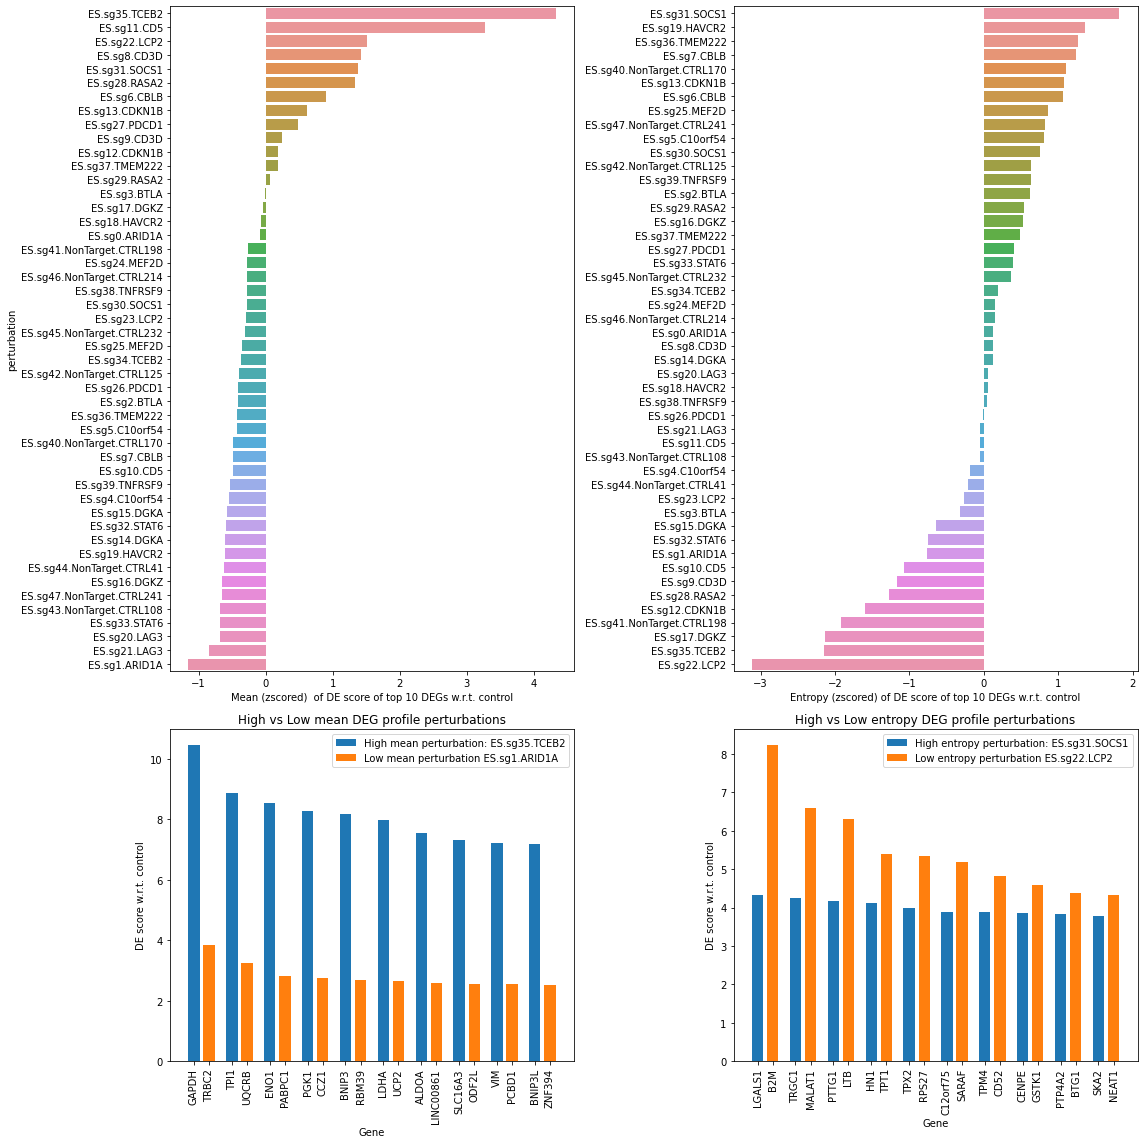

In [30]:
# plot
fig, axss = pl.subplots(2,2, figsize=[16,16], gridspec_kw={'height_ratios': [2, 1]})
n_top_show=10

ax = axss[0,0]
sns.barplot(data=tab.reset_index().sort_values('mean', ascending=False), y='index', x='mean', ax=ax)
ax.set_ylabel('perturbation')
ax.set_xlabel('Mean (zscored)  of DE score of top 10 DEGs w.r.t. control')

ax = axss[0,1]
sns.barplot(data=tab.reset_index().sort_values('entropy', ascending=False), y='index', x='entropy', ax=ax)
ax.set_ylabel('')
ax.set_xlabel('Entropy (zscored) of DE score of top 10 DEGs w.r.t. control')

ax = axss[1,0]
key = 'mean'#'entropy'
high = tab.index[np.argmax(tab[key])]
low = tab.index[np.argmin(tab[key])]
ax.bar(np.arange(n_top_show)-0.2, scores[high][:n_top_show], width=0.3, label=f'High {key} perturbation: {high}')
ax.bar(np.arange(n_top_show)+0.2, scores[low][:n_top_show], width=0.3, label=f'Low {key} perturbation {low}')
ax.legend()
ax.set_xticks(list(np.arange(n_top_show)-0.2) + list(np.arange(n_top_show)+0.2))
ax.set_xticklabels(list(names[high][:n_top_show]) + list(names[low][:n_top_show]), rotation=90)
ax.set_xlabel('Gene')
ax.set_ylabel('DE score w.r.t. control')
ax.set_title(f'High vs Low {key} DEG profile perturbations')

ax = axss[1,1]
key = 'entropy'
high = tab.index[np.argmax(tab[key])]
low = tab.index[np.argmin(tab[key])]
ax.bar(np.arange(n_top_show)-0.2, scores[high][:n_top_show], width=0.3, label=f'High {key} perturbation: {high}')
ax.bar(np.arange(n_top_show)+0.2, scores[low][:n_top_show], width=0.3, label=f'Low {key} perturbation {low}')
ax.legend()
ax.set_xticks(list(np.arange(n_top_show)-0.2) + list(np.arange(n_top_show)+0.2))
ax.set_xticklabels(list(names[high][:n_top_show]) + list(names[low][:n_top_show]), rotation=90)
ax.set_xlabel('Gene')
ax.set_ylabel('DE score w.r.t. control')
ax.set_title(f'High vs Low {key} DEG profile perturbations')

pl.tight_layout()
pl.savefig('../../figures/DEG_profile_ShifrutMarson2018.pdf', bbox_inches='tight')
pl.show()